<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Case_Aula_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Carregar a base de dados

<ipython-input-1-87b0ef359ac9>:18: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'])
<ipython-input-1-87b0ef359ac9>:18: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'])
<ipython-input-1-87b0ef359ac9>:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

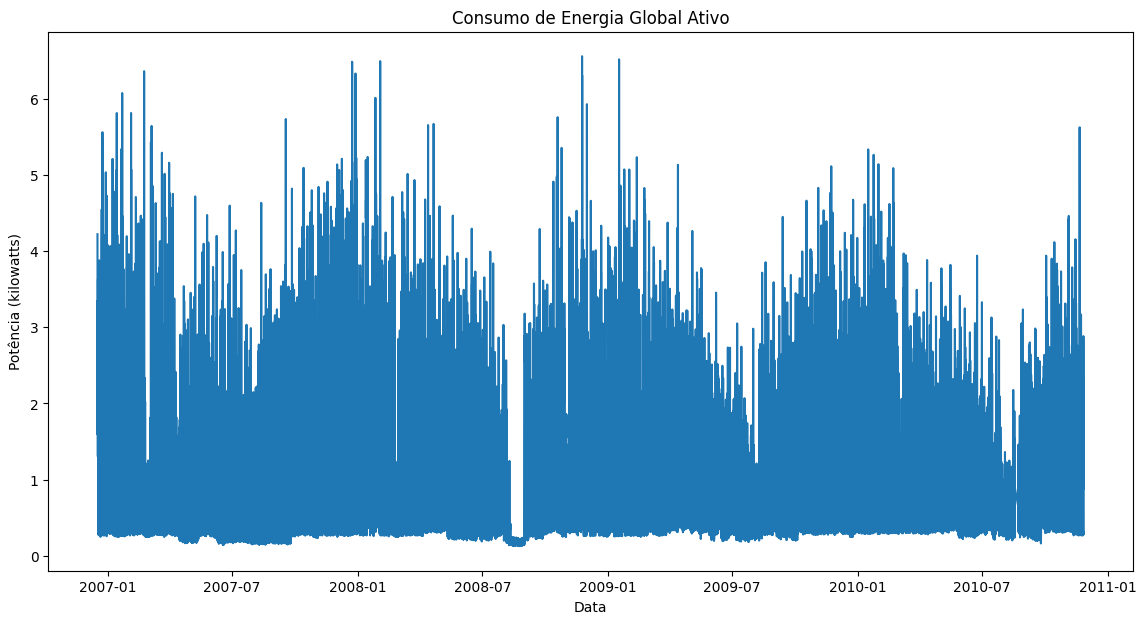

Tamanho do conjunto de treinamento: 27671 horas
Tamanho do conjunto de teste: 6918 horas


In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt

# URL do conjunto de dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'

# Baixar o arquivo zip
urllib.request.urlretrieve(url, 'household_power_consumption.zip')

# Descompactar o arquivo zip
with zipfile.ZipFile('household_power_consumption.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Ler o arquivo de dados
data = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['?'])

# Converter 'Global_active_power' para numérico
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')

# Definir o índice como a coluna de data e hora
data.set_index('Datetime', inplace=True)

# Interpolar valores faltantes na série temporal
data['Global_active_power'] = data['Global_active_power'].interpolate(method='time')

# Opcional: Preencher valores NaN restantes (se houver) no início ou fim da série
data['Global_active_power'] = data['Global_active_power'].fillna(method='bfill').fillna(method='ffill')

# Resample para dados horários
data = data.resample('H').mean()

# Visualizar os dados
plt.figure(figsize=(14,7))
plt.plot(data['Global_active_power'])
plt.title('Consumo de Energia Global Ativo')
plt.xlabel('Data')
plt.ylabel('Potência (kilowatts)')
plt.show()

# Dividir os dados em conjunto de treinamento e teste
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Exibir o tamanho de cada conjunto
print(f'Tamanho do conjunto de treinamento: {len(train_data)} horas')
print(f'Tamanho do conjunto de teste: {len(test_data)} horas')


##Visualização com Média Móvel

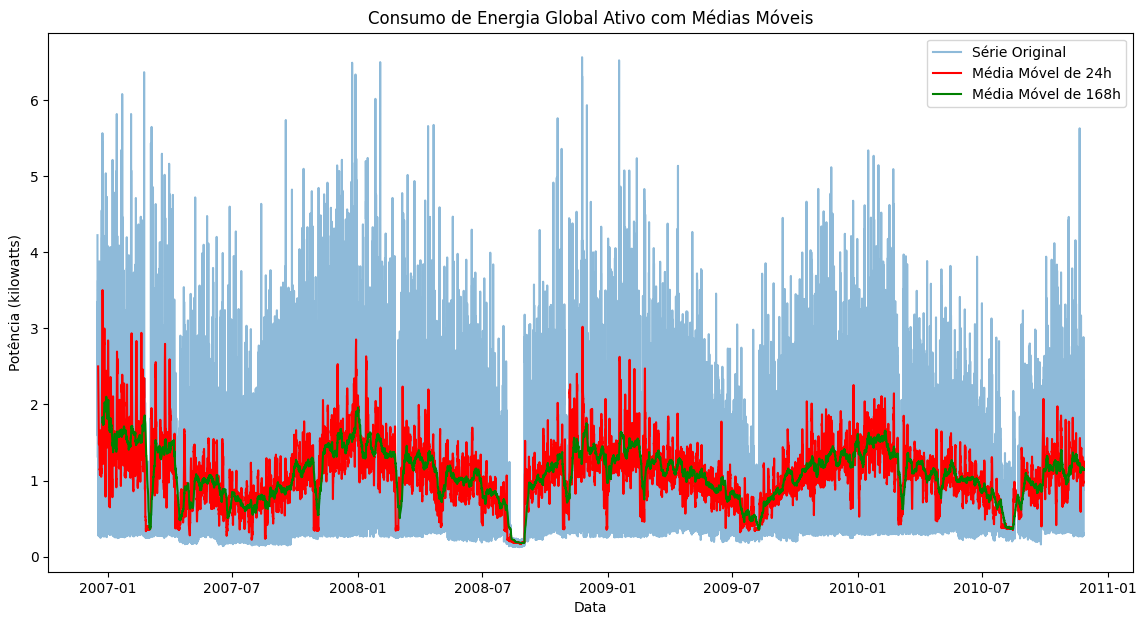

In [ ]:
# Calcular a média móvel com uma janela de 24 horas (1 dia)
data['SMA_24'] = data['Global_active_power'].rolling(window=24).mean()

# Calcular a média móvel com uma janela de 168 horas (1 semana)
data['SMA_168'] = data['Global_active_power'].rolling(window=168).mean()

# Plotar as médias móveis junto com a série original
plt.figure(figsize=(14,7))
plt.plot(data['Global_active_power'], label='Série Original', alpha=0.5)
plt.plot(data['SMA_24'], label='Média Móvel de 24h', color='red')
plt.plot(data['SMA_168'], label='Média Móvel de 168h', color='green')
plt.title('Consumo de Energia Global Ativo com Médias Móveis')
plt.xlabel('Data')
plt.ylabel('Potência (kilowatts)')
plt.legend()
plt.show()

## Decomposição

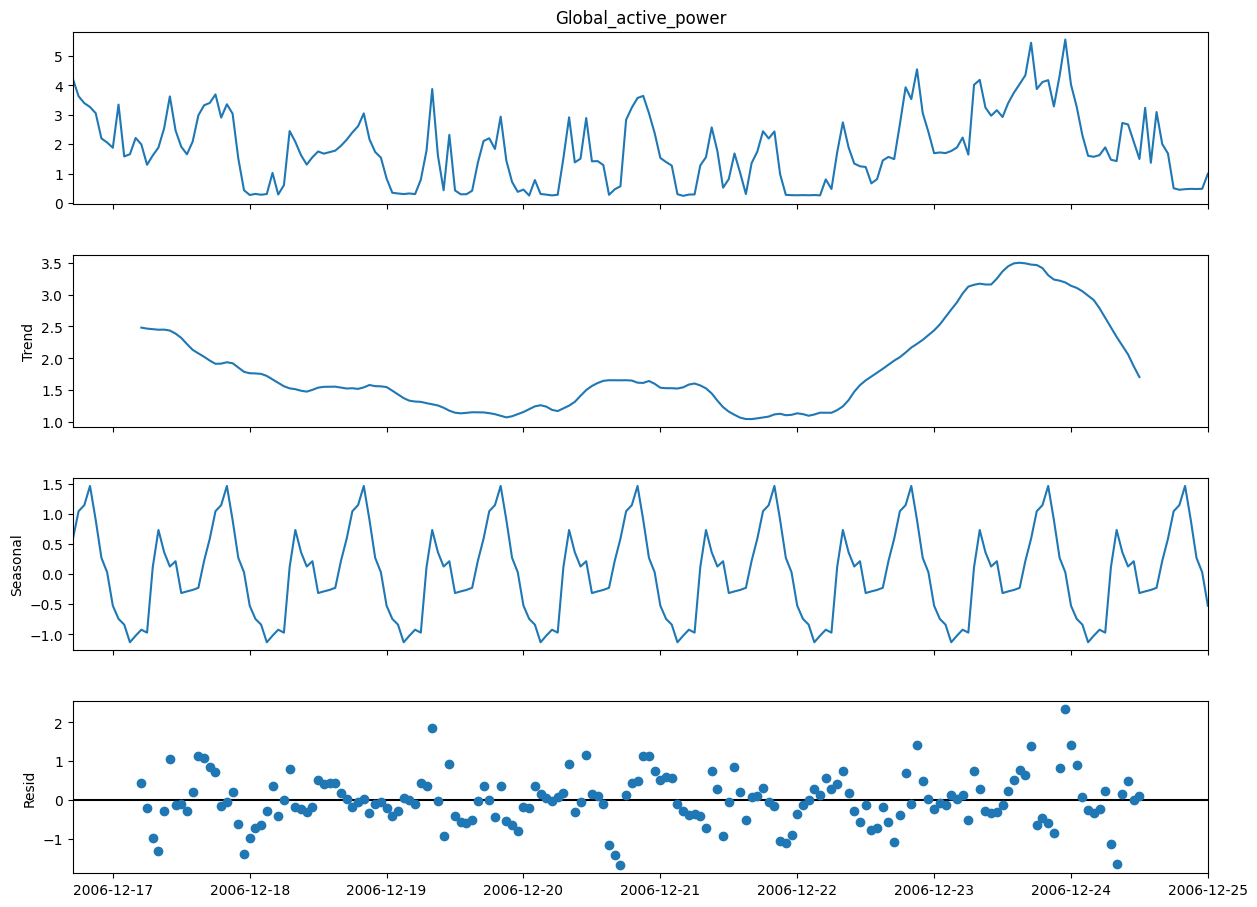

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Certifique-se de que não há valores faltantes
data_decomp = data['Global_active_power'].dropna()

# Realizar a decomposição aditiva
decomposition = seasonal_decompose(data_decomp[:200], model='additive', period=24)

# Plotar os componentes
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

## Visualização dos resíduos

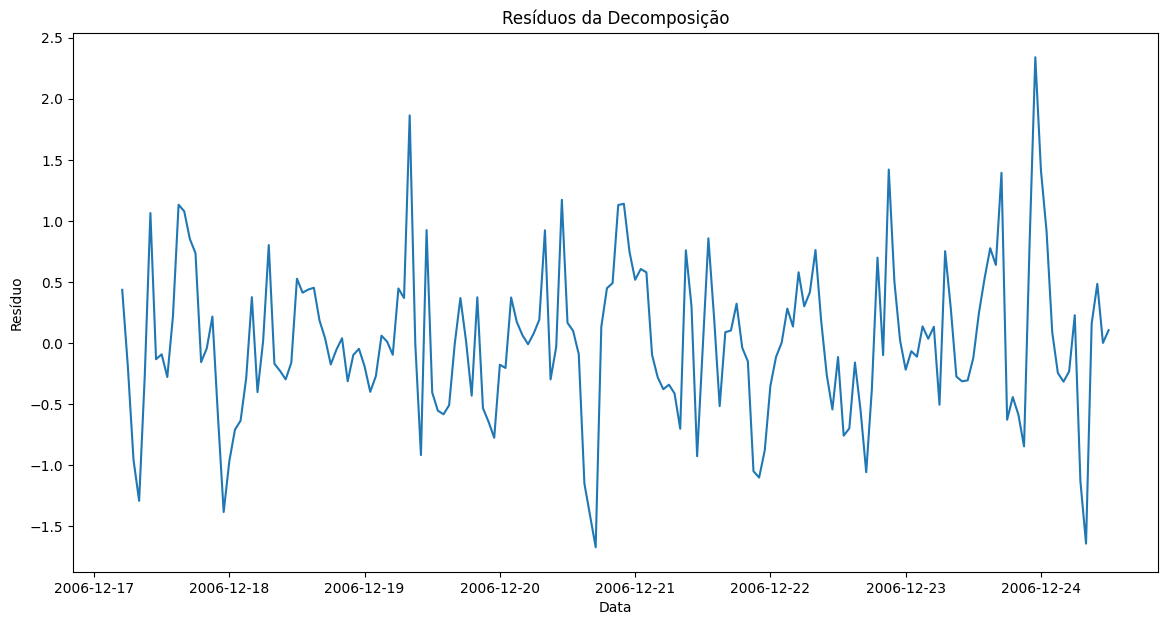

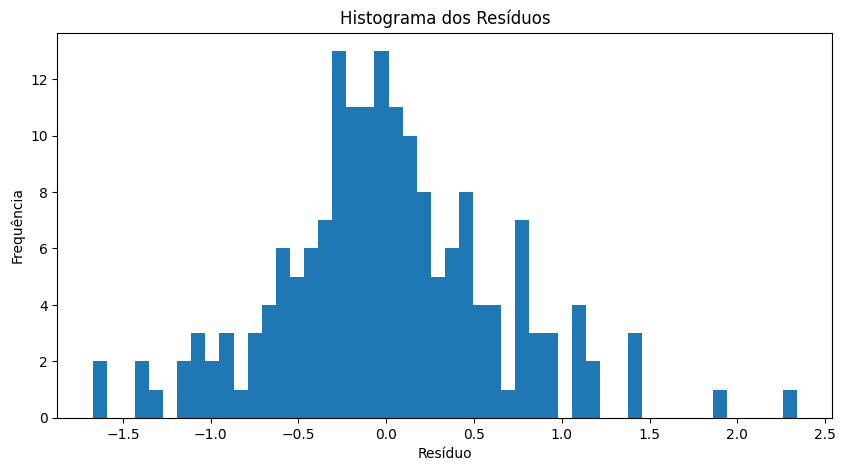

In [ ]:
# Plotar os resíduos
plt.figure(figsize=(14,7))
plt.plot(decomposition.resid)
plt.title('Resíduos da Decomposição')
plt.xlabel('Data')
plt.ylabel('Resíduo')
plt.show()

# Plotar histograma dos resíduos
plt.figure(figsize=(10,5))
plt.hist(decomposition.resid.dropna(), bins=50)
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

##Previsões

In [ ]:
#!pip install pmdarima

### Teste Estacionariedade

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Função para o teste de Dickey-Fuller Aumentado (ADF)
def adf_test(series, title=''):
    print(f'Resultados do Teste ADF para {title}')
    result = adfuller(series.dropna())
    labels = ['Estatística ADF', 'p-valor', '#Lags Usados', 'Número de Observações']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Valor Crítico ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Conclusão: Série Estacionária (Rejeita H0)")
    else:
        print("Conclusão: Série Não Estacionária (Não Rejeita H0)")
    print('\n')

# Aplicar o teste ADF na série de treinamento
adf_test(train_data['Global_active_power'], 'Global Active Power - Treinamento')

Resultados do Teste ADF para Global Active Power - Treinamento
Estatística ADF         -1.266267e+01
p-valor                  1.294752e-23
#Lags Usados             4.900000e+01
Número de Observações    2.762100e+04
Valor Crítico (1%)      -3.430587e+00
Valor Crítico (5%)      -2.861645e+00
Valor Crítico (10%)     -2.566826e+00
Conclusão: Série Estacionária (Rejeita H0)




### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Definir a variável dependente
y_train = train_data['Global_active_power']
y_test = test_data['Global_active_power']


In [ ]:
# Ajustar o modelo ARIMA(2,1,2)
model_212 = ARIMA(y_train, order=(2,1,2))
model_212_fit = model_212.fit()

# Resumo do modelo
print(model_212_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                27671
Model:                  ARIMA(2, 1, 2)   Log Likelihood              -26601.652
Date:                 Mon, 23 Sep 2024   AIC                          53213.305
Time:                         12:15:54   BIC                          53254.445
Sample:                     12-16-2006   HQIC                         53226.556
                          - 02-11-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3916      0.022     64.460      0.000       1.349       1.434
ar.L2         -0.5473      0.014    -39.634      0.000      -0.574      -0.520
ma.L1         -1.6363      0.023    -71.351 

In [ ]:
# Ajustar o modelo ARIMA(3,1,3)
model_1202 = ARIMA(y_train, order=(24,0,0))
model_1202_fit = model_1202.fit()

# Resumo do modelo
print(model_1202_fit.summary())


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                27671
Model:                 ARIMA(24, 0, 0)   Log Likelihood              -25515.642
Date:                 Mon, 23 Sep 2024   AIC                          51083.284
Time:                         12:19:56   BIC                          51297.216
Sample:                     12-16-2006   HQIC                         51152.192
                          - 02-11-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1145      0.039     28.590      0.000       1.038       1.191
ar.L1          0.6944      0.005    145.523      0.000       0.685       0.704
ar.L2         -0.0656      0.006    -11.348 

In [ ]:
# Número de passos para prever
n_steps = len(y_test)

# Fazer previsões
forecast_212 = model_212_fit.forecast(steps=n_steps)

# Criar uma Série com as previsões
forecast_212_series = pd.Series(forecast_212, index=y_test.index)

# Fazer previsões
forecast_1202 = model_1202_fit.forecast(steps=n_steps)

# Criar uma Série com as previsões
forecast_1202_series = pd.Series(forecast_1202, index=y_test.index)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Função para calcular as métricas de erro
def evaluate_forecast(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'\nDesempenho do {model_name}:')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')

In [ ]:
evaluate_forecast(y_test, forecast_212_series, 'Modelo ARIMA(2,1,2)')
evaluate_forecast(y_test, forecast_1202_series, 'Modelo ARIMA(24,0,0)')



Desempenho do Modelo ARIMA(2,1,2):
MAE: 0.7502
MSE: 0.7509
RMSE: 0.8665

Desempenho do Modelo ARIMA(12,1,2):
MAE: 0.6239
MSE: 0.5417
RMSE: 0.7360


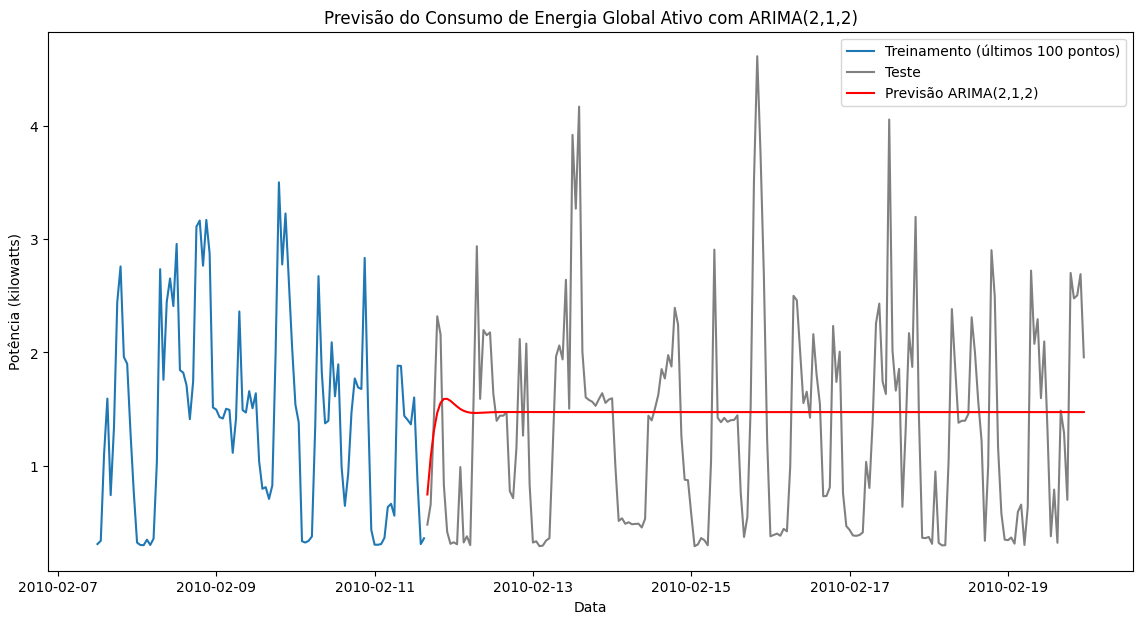

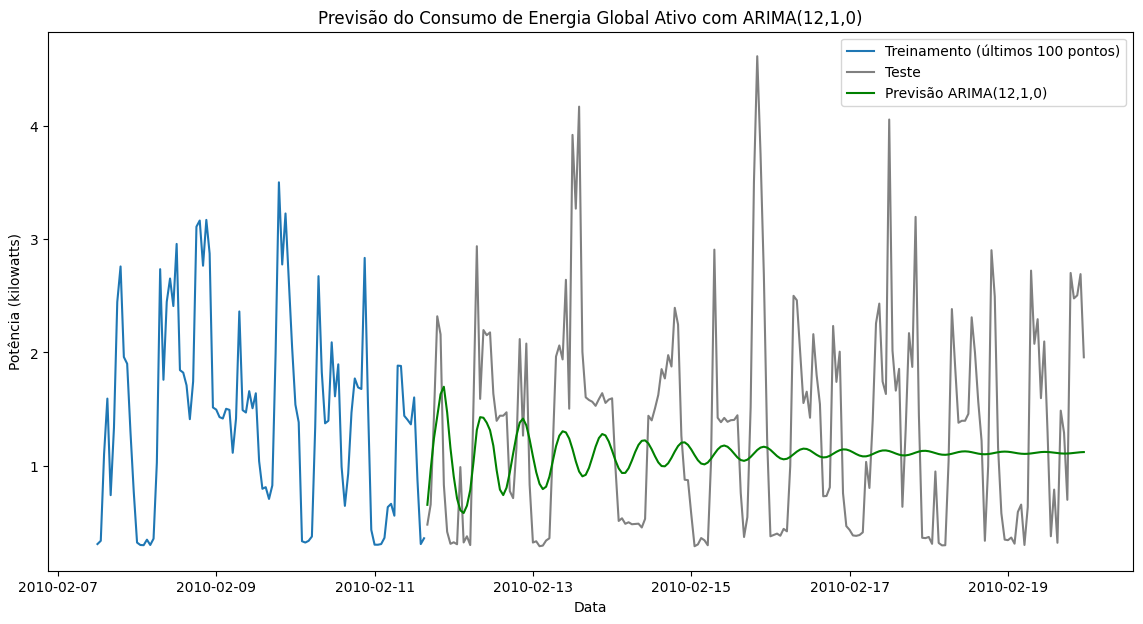

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(y_train[-100:], label='Treinamento (últimos 100 pontos)')
plt.plot(y_test[:200], label='Teste', color='gray')
plt.plot(forecast_212_series[:200], label='Previsão ARIMA(2,1,2)', color='red')
plt.title('Previsão do Consumo de Energia Global Ativo com ARIMA(2,1,2)')
plt.xlabel('Data')
plt.ylabel('Potência (kilowatts)')
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(y_train[-100:], label='Treinamento (últimos 100 pontos)')
plt.plot(y_test[:200], label='Teste', color='gray')
plt.plot(forecast_1202_series[:200], label='Previsão ARIMA(12,1,0)', color='green')
plt.title('Previsão do Consumo de Energia Global Ativo com ARIMA(12,1,0)')
plt.xlabel('Data')
plt.ylabel('Potência (kilowatts)')
plt.legend()
plt.show()


##Outros métodos Machine Methods

### Pré Processamento

In [ ]:
def create_features(df, target_column, lags, rolling_windows):
    """
    Cria features de defasagens e estatísticas de janelas móveis para a série temporal.

    :param df: DataFrame com a série temporal.
    :param target_column: Nome da coluna alvo.
    :param lags: Lista de defasagens a serem criadas.
    :param rolling_windows: Lista de tamanhos de janelas para as estatísticas móveis.
    :return: DataFrame com as features adicionadas.
    """
    # Iniciar um DataFrame vazio com o mesmo índice
    df_feat = pd.DataFrame(index=df.index)

    # Criar features de defasagens (lags)
    for lag in lags:
        df_feat[f'lag_{lag}'] = df[target_column].shift(lag)

    # Criar features de estatísticas móveis
    for window in rolling_windows:
        rolled = df[target_column].shift(1).rolling(window=window)
        df_feat[f'rolling_mean_{window}'] = rolled.mean()
        df_feat[f'rolling_std_{window}'] = rolled.std()
        df_feat[f'rolling_min_{window}'] = rolled.min()
        df_feat[f'rolling_max_{window}'] = rolled.max()

    # Opcional: Adicionar a variável alvo ao DataFrame de features
    df_feat[target_column] = df[target_column]

    # Remover linhas com valores NaN gerados pelas defasagens e estatísticas móveis
    df_feat.dropna(inplace=True)

    return df_feat


In [ ]:
# Definir as defasagens e janelas móveis
lags = [1, 2, 4, 12, 24, 36] + list(range(48, 361, 12))
rolling_windows = [3, 6, 12, 24, 48, 72, 168]

# Gerar features para o conjunto de treinamento
train_features = create_features(train_data, target_column='Global_active_power', lags=lags, rolling_windows=rolling_windows)

# Remover linhas com valores NaN gerados pelas defasagens e estatísticas móveis
train_features.dropna(inplace=True)

# Separar variável alvo e features
y_train = train_features['Global_active_power']
X_train = train_features.drop('Global_active_power', axis=1)


In [ ]:
# Combinar as últimas observações do conjunto de treinamento com o conjunto de teste
max_lag = max(lags + rolling_windows)
test_data_prep = pd.concat([train_data.iloc[-max_lag:], test_data])

# Gerar features para o conjunto de teste
test_features = create_features(test_data_prep, target_column='Global_active_power', lags=lags, rolling_windows=rolling_windows)

# Remover as primeiras linhas que pertencem ao treinamento
test_features = test_features.loc[test_data.index]

# Remover linhas com valores NaN gerados pelas defasagens e estatísticas móveis
test_features.dropna(inplace=True)

# Separar variável alvo e features
y_test = test_features['Global_active_power']
X_test = test_features.drop('Global_active_power', axis=1)


###Treinando XGBoost

In [ ]:
# Importar bibliotecas necessárias
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Criar a instância do modelo
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Fazer previsões
y_pred = model.predict(X_test)

# Calcular métricas de erro
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


MSE: 0.2292
RMSE: 0.4788
MAE: 0.3312


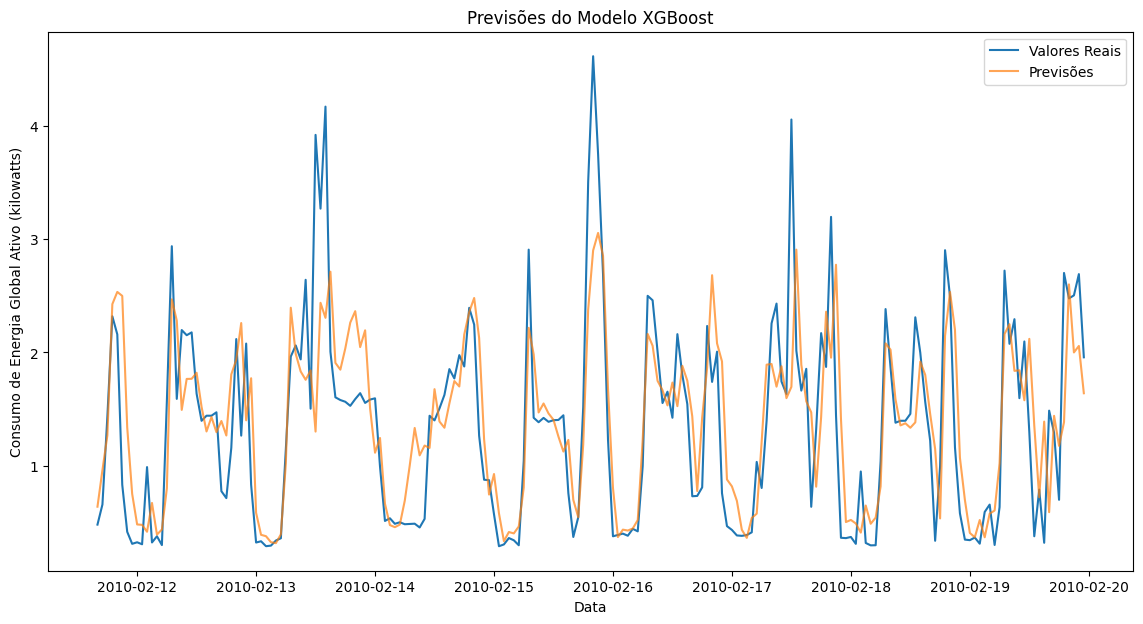

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(y_test.index[:200], y_test[:200], label='Valores Reais')
plt.plot(y_test.index[:200], y_pred[:200], label='Previsões', alpha=0.7)
plt.title('Previsões do Modelo XGBoost')
plt.xlabel('Data')
plt.ylabel('Consumo de Energia Global Ativo (kilowatts)')
plt.legend()
plt.show()


In [ ]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train_array = X_train.values
y_train_array = y_train.values

X_test_array = X_test.values
y_test_array = y_test.values


In [ ]:
# Redimensionar para (samples, timesteps, features)
X_train_cnn = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))
X_test_cnn = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))


In [ ]:
# Normalizar as features
scaler = StandardScaler()
X_train_cnn_reshaped = X_train_cnn.reshape(-1, X_train_cnn.shape[-1])
X_train_cnn_reshaped = scaler.fit_transform(X_train_cnn_reshaped)
X_train_cnn = X_train_cnn_reshaped.reshape(X_train_cnn.shape)

X_test_cnn_reshaped = X_test_cnn.reshape(-1, X_test_cnn.shape[-1])
X_test_cnn_reshaped = scaler.transform(X_test_cnn_reshaped)
X_test_cnn = X_test_cnn_reshaped.reshape(X_test_cnn.shape)


In [ ]:
# Definir o modelo
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Treinar o modelo
from tensorflow.keras.callbacks import ModelCheckpoint

# Configurar o callback ModelCheckpoint
checkpoint_filepath = 'melhor_modelo.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1  # Opcional: Exibe mensagens quando o modelo é salvo
)

history = model.fit(
    X_train_cnn,
    y_train_array,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_array),
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
852/854 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4293
Epoch 1: val_loss improved from inf to 0.24836, saving model to melhor_modelo.keras
854/854 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4291 - val_loss: 0.2484
Epoch 2/20
851/854 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3361
Epoch 2: val_loss improved from 0.24836 to 0.23889, saving model to melhor_modelo.keras
854/854 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.3361 - val_loss: 0.2389
Epoch 3/20
853/854 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3230
Epoch 3: val_loss did not improve from 0.23889
854/854 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3230 - val_loss: 0.2419
Epoch 4/20
848/854 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3154
Epoch 4: val_loss improved from 0.23889 to 0.23657, saving model to melhor_modelo.keras
854/854 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3154 - val_loss: 0.2366
Epoch 5/20
848/854 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3117
Epoch 5: val_loss did not improve from 0.23657
854/8

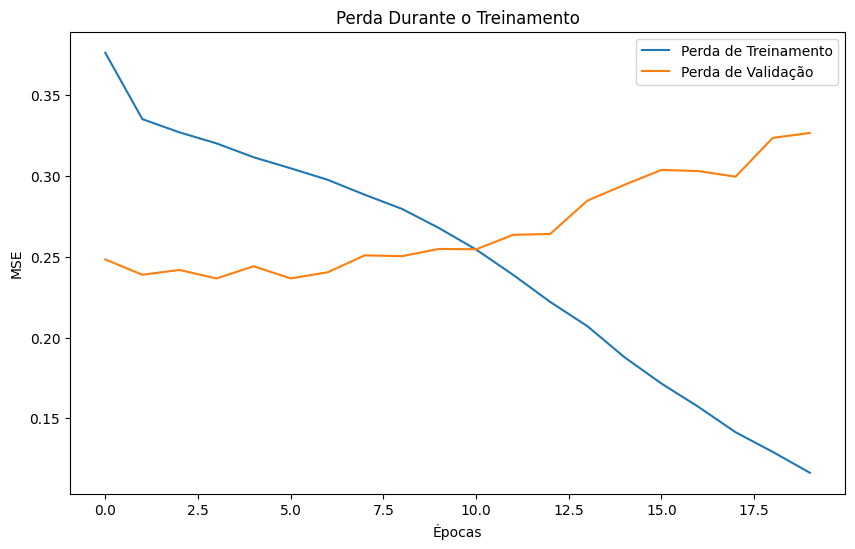

In [ ]:
# Plotar a função de perda
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
# Fazer previsões
y_pred_cnn = model.predict(X_test_cnn)

# Calcular métricas de erro
mse = mean_squared_error(y_test_array, y_pred_cnn)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_array, y_pred_cnn)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MSE: 0.2366
RMSE: 0.4864
MAE: 0.3346


XGBOOST:

MSE: 0.2292

RMSE: 0.4788

MAE: 0.3312

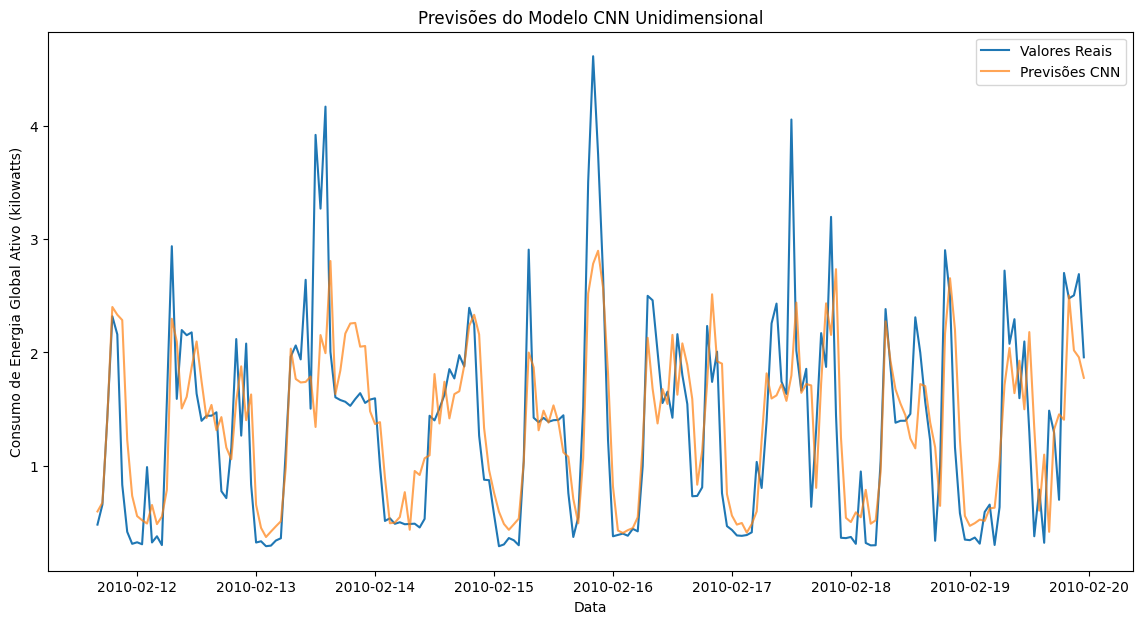

In [ ]:
# Converter y_test_array e y_pred_cnn para séries Pandas para facilitar o plot
y_test_series = pd.Series(y_test_array.flatten(), index=y_test.index[-len(y_test_array):])
y_pred_series = pd.Series(y_pred_cnn.flatten(), index=y_test.index[-len(y_pred_cnn):])

# Plotar os valores reais vs. previstos
plt.figure(figsize=(14,7))
plt.plot(y_test_series.index[:200], y_test_series[:200], label='Valores Reais')
plt.plot(y_pred_series.index[:200], y_pred_series[:200], label='Previsões CNN', alpha=0.7)
plt.title('Previsões do Modelo CNN Unidimensional')
plt.xlabel('Data')
plt.ylabel('Consumo de Energia Global Ativo (kilowatts)')
plt.legend()
plt.show()
